In [ ]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# **Import Data**

In [ ]:
df = pd.read_csv('/content/AAPL.csv', parse_dates = ['Date'], index_col = 'Date')
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-12,39.625000,40.972500,39.377499,40.677502,38.837940,243278000
2018-02-13,40.487499,41.187500,40.412498,41.084999,39.227001,130196800
2018-02-14,40.759998,41.884998,40.720001,41.842499,39.950237,162579600
2018-02-15,42.447498,43.272499,42.250000,43.247501,41.291702,204588800
2018-02-16,43.090000,43.705002,42.942501,43.107498,41.158035,160704400
...,...,...,...,...,...,...
2023-02-03,148.029999,157.380005,147.830002,154.500000,154.500000,154279900
2023-02-06,152.570007,153.100006,150.779999,151.729996,151.729996,69858300
2023-02-07,150.639999,155.229996,150.639999,154.649994,154.649994,83322600


# **Visualize Adj Close price history**

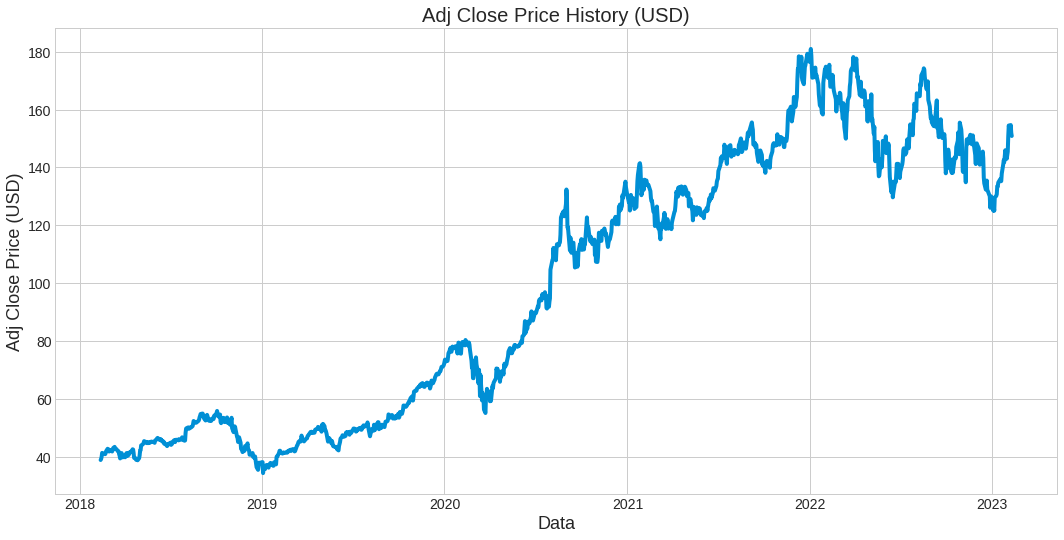

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('Adj Close Price History (USD)')
plt.xlabel('Data', fontsize = 18)
plt.ylabel('Adj Close Price (USD)', fontsize = 18)
plt.plot(df['Adj Close'])
plt.show()

# **Preprocessing**

In [ ]:
#Create dataframe with Adj Close
adjClose_data = df[['Adj Close']]

adjClose_data

,Adj Close
Date,
2018-02-12,38.837940
2018-02-13,39.227001
2018-02-14,39.950237
2018-02-15,41.291702
2018-02-16,41.158035
...,...
2023-02-03,154.500000
2023-02-06,151.729996
2023-02-07,154.649994


In [ ]:
#Normilze The Data
scaler = MinMaxScaler((0,1))
adjClose_data_scaled = scaler.fit_transform(adjClose_data)
adjClose_data_scaled

array([[0.03087865],
       [0.03353163],
       [0.03846334],
       ...,
       [0.82059522],
       [0.80197951],
       [0.7948196 ]])

# **Split The Dataset**

In [ ]:
#split 80% of data into training set
last_row = int(len(adjClose_data_scaled) * 0.8)

train_data = adjClose_data_scaled[:last_row]
X_train = []
y_train = []

for i in range(60, len(train_data)):
  X_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

In [ ]:
#Convert the data into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(946, 60, 1)

# **Build LSTM Model**

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
model.compile(optimizer='adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#train The Model
model.fit(X_train, y_train, batch_size = 1, epochs = 1)

946/946 [==============================] - 20s 19ms/step - loss: 0.0022


# **Test The Model**

In [ ]:
#Craete Testset
test_set = adjClose_data_scaled[last_row-60:]

X_test = []
y_test = adjClose_data_scaled[last_row:]
y_test = scaler.inverse_transform(y_test)

for i in range (60, len(test_set)):
  X_test.append(test_set[i-60:i, 0])

In [ ]:
#convert the data into numpy array
X_test = np.array(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(252, 60, 1)

In [ ]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

8/8 [==============================] - 0s 12ms/step


# **Evaluate The Model**

In [ ]:
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
rmse

5.6530402845904595

# **Visualize The Dataset**

<ipython-input-144-f6b72561fec9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


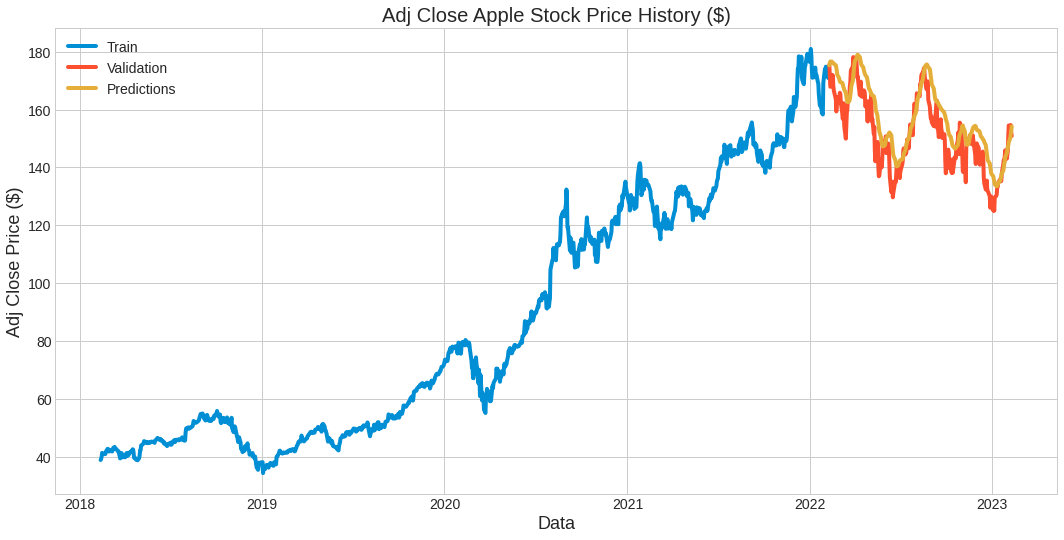

In [ ]:
train = adjClose_data[:last_row]
valid = adjClose_data[last_row:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Adj Close Apple Stock Price History ($)')
plt.xlabel('Data', fontsize = 18)
plt.ylabel('Adj Close Price ($)', fontsize = 18)
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'])
plt.show()

In [ ]:
#show The Validation data and Prediction
valid

,Adj Close,Predictions
Date,,
2022-02-09,175.486099,175.269684
2022-02-10,171.344833,176.119339
2022-02-11,167.880508,176.613632
2022-02-14,168.119431,176.603394
2022-02-15,172.011826,176.315079
...,...,...
2023-02-03,154.500000,148.717407
2023-02-06,151.729996,150.204590
2023-02-07,154.649994,151.592972
